In [1]:
import numpy as np
import re
import os
import path

import h5py
from numpy import fft
import lmfit
from lmfit import Parameters, minimize
from lmfit.printfuncs import fit_report
import matplotlib.pyplot as plt

from scipy.special import dawsn

import sys
sys.path.insert(0, r'C:\Users\shadd\OneDrive\Documents\Python\frxas.py')

from frxas import time_domain, models, hdf5_io
%reload_ext autoreload
%autoreload 2

In [2]:
Signal = lmfit.Model(time_domain.fft_shape)

In [3]:
%%time
direc = r'D:\UW Research\fr-XAS July 2018\Data\10% O2\1 Hz 150 mV'
point = r'\P5'
amp = ''
file = r'\R1'

ti, V, J, Ir = time_domain.extract_data(direc, point, amp, file, end=200)
match = re.search(r'\d+% O2', direc)
if match:
    gas = match.group()
f = time_domain.get_freq(direc, point, amp, file)
Ns = ti.size

Wall time: 8.29 s


In [4]:
init_params = lmfit.Parameters()

init_params.add('harmonic', value=1, vary=False)
init_params.add('re_comp', value=1)
init_params.add('im_comp', value=1)

### Broken as of 5/20/20 when I rewrote the phase_align method

In [5]:
%%time
b = 80.3998#0.2 * f * (ti[-1]+ti[1])
init_params.add('freq_in', value=f, vary=False)
init_params.add('window_param', value=b, vary=False)
V_win = time_domain.gauss_window(V, f, ti, b)
freqs = np.fft.fftshift(np.fft.fftfreq(Ns, ti[1]))
# np.sqrt(np.mean(y**2))
V_win_fft = np.fft.fftshift(np.fft.fft(V_win)/(Ns*np.pi))
result = Signal.fit(V_win_fft, params=init_params, frequencies=freqs )
fit_Sig = Signal.eval(params=result.params, frequencies=freqs)
print("Amp: ", np.sqrt(result.params['re_comp'].value**2 + result.params['im_comp'].value**2))
print("Angle: ", np.angle(result.params['re_comp'].value + 1j* result.params['im_comp'].value, deg=True))
V_adj = time_domain.phase_align(ti, V, V, f, phase=-90)
result

Amp:  0.14941625357507082
Angle:  -89.92566923834964


TypeError: phase_align() missing 1 required positional argument: 'window_param'

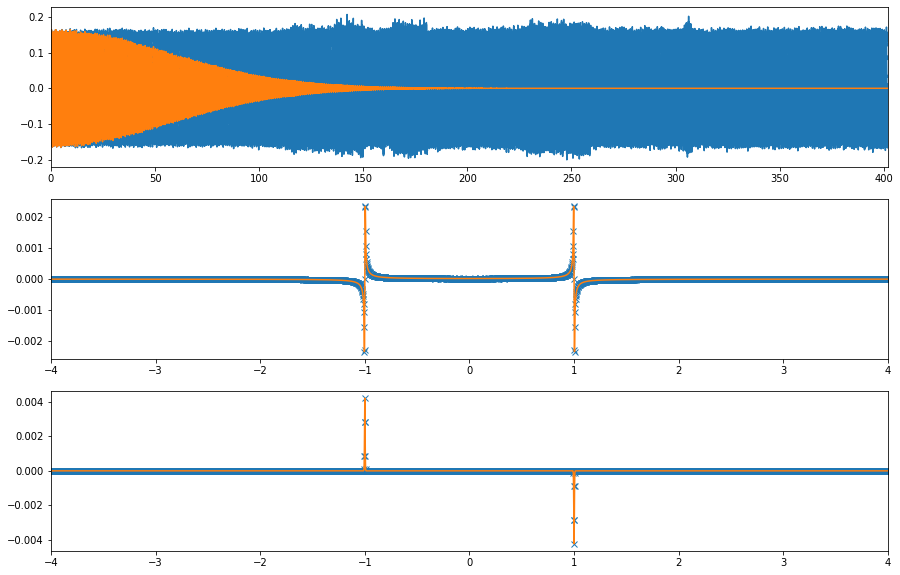

In [6]:
fit_Sig = Signal.eval(params=result.params, frequencies=freqs)

_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15, 10))

ax1.plot(ti, V)
ax1.plot(ti, V_win)

ax2.plot(freqs, V_win_fft.real, 'x')
ax2.plot(freqs, fit_Sig.real)

ax3.plot(freqs, V_win_fft.imag, 'x')
ax3.plot(freqs, fit_Sig.imag)

ax1.set_xlim(0, ti[-1])
ax2.set_xlim(-4*f, 4*f)
ax3.set_xlim(-4*f, 4*f)

idx_p = time_domain.freq_bin(f, freqs,1)[-1]

plt.show()

In [7]:
dat_win = time_domain.gauss_window(J, f, ti, b)
freqs = np.fft.fftshift(np.fft.fftfreq(Ns, ti[1]))
dat_fft = np.fft.fftshift(np.fft.fft(dat_win)/(Ns*np.pi))

dat_ffts = [dat_fft, dat_fft, dat_fft]
freqs2 = [freqs, freqs, freqs]

params = lmfit.Parameters()

## Using lmfit minimizer.

In [8]:
for iy, _ in enumerate(dat_ffts):
    params.add('freq_in_%i' % (iy+1), value=f, vary=False)
    params.add('window_param_%i' % (iy+1), value=b, vary=False)
    params.add('harmonic_%i' % (iy+1), value=iy+1, vary=False)
    params.add('re_comp_%i' % (iy+1), value=0)
    params.add('im_comp_%i' % (iy+1), value=-1)
    
params

name,value,initial value,min,max,vary
freq_in_1,1.00000400,1.000004,-inf,inf,False
window_param_1,80.3998000,80.3998,-inf,inf,False
harmonic_1,1.00000000,1,-inf,inf,False
re_comp_1,0.00000000,0,-inf,inf,True
im_comp_1,-1.00000000,-1,-inf,inf,True
freq_in_2,1.00000400,1.000004,-inf,inf,False
window_param_2,80.3998000,80.3998,-inf,inf,False
harmonic_2,2.00000000,2,-inf,inf,False
re_comp_2,0.00000000,0,-inf,inf,True
im_comp_2,-1.00000000,-1,-inf,inf,True


In [9]:
mini = lmfit.Minimizer(models.objective_fun, params, fcn_args=(freqs2, dat_ffts, time_domain.fft_shape))

In [10]:
out = mini.minimize()
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 2894400
    # variables        = 6
    chi-square         = 8.6738e-10
    reduced chi-square = 2.9968e-16
    Akaike info crit   = -1.0346e+08
    Bayesian info crit = -1.0346e+08
[[Variables]]
    freq_in_1:       1.000004 (fixed)
    window_param_1:  80.3998 (fixed)
    harmonic_1:      1 (fixed)
    re_comp_1:       8.5673e-05 +/- 2.1725e-07 (0.25%) (init = 0)
    im_comp_1:      -2.1297e-04 +/- 2.1725e-07 (0.10%) (init = -1)
    freq_in_2:       1.000004 (fixed)
    window_param_2:  80.3998 (fixed)
    harmonic_2:      2 (fixed)
    re_comp_2:      -3.5185e-05 +/- 2.1725e-07 (0.62%) (init = 0)
    im_comp_2:      -3.0381e-05 +/- 2.1725e-07 (0.72%) (init = -1)
    freq_in_3:       1.000004 (fixed)
    window_param_3:  80.3998 (fixed)
    harmonic_3:      3 (fixed)
    re_comp_3:       1.8144e-06 +/- 2.1725e-07 (11.97%) (init = 0)
    im_comp_3:       1.7942e-05 +/- 2.1725e-07 (1

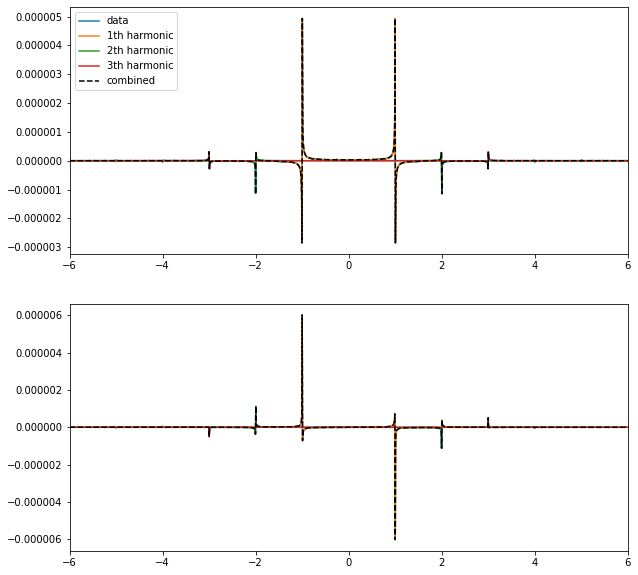

In [11]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(10,10))
ax1.plot(freqs, dat_fft.real, label='data')
ax2.plot(freqs, dat_fft.imag, label='data')

comb = np.zeros(np.shape(freqs), dtype=complex)

for iy in range(0, 3):
    ax1.plot(freqs, models.dataset_fun(out.params, iy, freqs, time_domain.fft_shape).real, label='{:d}th harmonic'.format(iy+1))
    ax2.plot(freqs, models.dataset_fun(out.params, iy, freqs, time_domain.fft_shape).imag, label='{:d}th harmonic'.format(iy+1))
    comb += models.dataset_fun(out.params, iy, freqs, time_domain.fft_shape)

ax1.plot(freqs, comb.real, 'k--', label='combined')
ax2.plot(freqs, comb.imag, 'k--', label='combined')

ax1.set_xlim(-6*f, 6*f)
ax2.set_xlim(-6*f, 6*f)
ax1.legend(loc='upper left')

plt.show()

## But it's much easier to make a compound model using prefixes and specifying independent variables

In [12]:
harms = 3
params = lmfit.Parameters()
model = None
for iy in range(0, harms+1):
    if model:
        model += lmfit.Model(time_domain.fft_shape, prefix=f'h{iy}_', independent_vars=['frequencies', 'freq_in', 'window_param'])
    else:
        model = lmfit.Model(time_domain.fft_shape, prefix=f'h{iy}_', independent_vars=['frequencies', 'freq_in', 'window_param'])
    params.add('h%i_harmonic' % iy, value=iy, vary=False)
    params.add('h%i_re_comp' % iy, value=0)
    params.add('h%i_im_comp' % iy, value=-1)

In [13]:
ref_win = time_domain.gauss_window(V, f, ti, b)
sig_win = time_domain.gauss_window(Ir, f, ti, b)

freqs = np.fft.fftshift(np.fft.fftfreq(Ns, ti[1]))


ref_fft = np.fft.fftshift(np.fft.fft(ref_win)/(Ns*np.pi))
sig_fft = np.fft.fftshift(np.fft.fft(sig_win)/(Ns*np.pi))

In [14]:
fit_kws={'ftol':1e-13, 'xtol':1e-13}
ref_fit = model.fit(ref_fft, params=params, **{'frequencies':freqs, 'freq_in':f, 'window_param':b}, fit_kws=fit_kws)
sig_fit = model.fit(sig_fft, params=params, frequencies=freqs, freq_in=f, window_param=b, fit_kws=fit_kws)

In [15]:
print(fit_report(ref_fit))
print(fit_report(sig_fit))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 964800
    # variables        = 8
    chi-square         = 2.6569e-07
    reduced chi-square = 2.7539e-13
    Akaike info crit   = -27902590.3
    Bayesian info crit = -27902496.1
##  Warning: uncertainties could not be estimated:
    h0_harmonic:  at initial value
    h0_im_comp:   at initial value
    h1_harmonic:  at initial value
    h2_harmonic:  at initial value
    h3_harmonic:  at initial value
[[Variables]]
    h0_harmonic:  0 (fixed)
    h0_re_comp:  -3.2891e-05 (init = 0)
    h0_im_comp:  -1.00000000 (init = -1)
    h1_harmonic:  1 (fixed)
    h1_re_comp:   1.9377e-04 (init = 0)
    h1_im_comp:  -0.14941622 (init = -1)
    h2_harmonic:  2 (fixed)
    h2_re_comp:  -4.1380e-05 (init = 0)
    h2_im_comp:  -3.1431e-05 (init = -1)
    h3_harmonic:  3 (fixed)
    h3_re_comp:  -3.9512e-05 (init = 0)
    h3_im_comp:   2.5726e-05 (init = -1)
[[Fit Statistics]]
    # fitting method

In [1]:
sig_adj, sig_adj_fit = time_domain.phase_align(ti, V, Ir, f, b, phase=-90, harmonics=3)

NameError: name 'time_domain' is not defined

c:\users\shadd\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


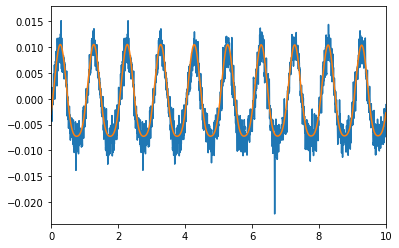

In [18]:
_, ax = plt.subplots()
ax.plot(ti, sig_win)
ax.plot(ti, sig_adj)
ax.set_xlim(0,10)
plt.show()

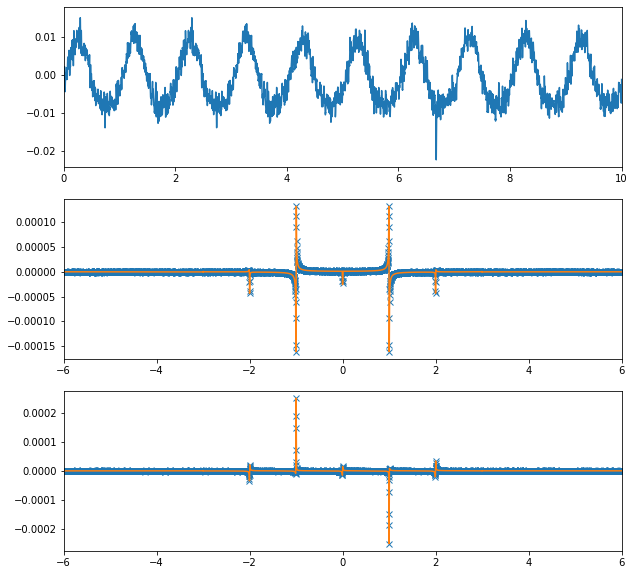

In [19]:
fig, (ax1,ax2, ax3) = plt.subplots(nrows=3, figsize=(10,10))
ax1.plot(ti, sig_win)

ax2.plot(freqs, sig_fft.real, 'x')
ax3.plot(freqs, sig_fft.imag, 'x')

ax2.plot(freqs, sig_fit.best_fit.real)
ax3.plot(freqs, sig_fit.best_fit.imag)

ax1.set_xlim(0, 10)
ax2.set_xlim(-6*f, 6*f)
ax3.set_xlim(-6*f, 6*f)
plt.show()

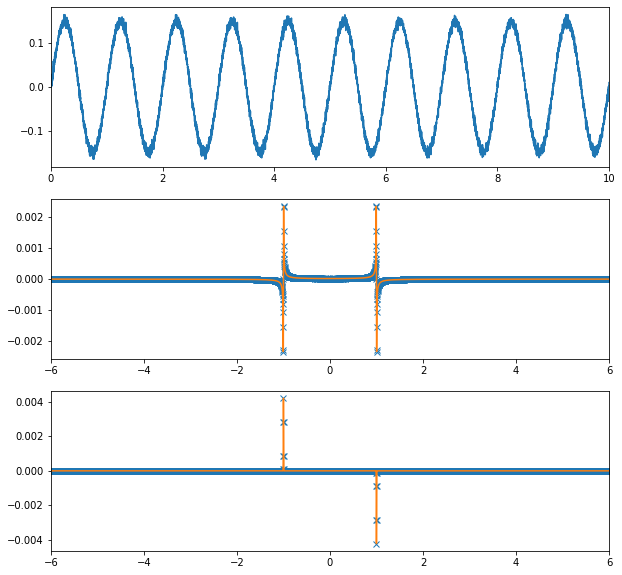

In [20]:
fig, (ax1,ax2, ax3) = plt.subplots(nrows=3, figsize=(10,10))
ax1.plot(ti, ref_win)

ax2.plot(freqs, ref_fft.real, 'x')
ax3.plot(freqs, ref_fft.imag, 'x')

ax2.plot(freqs, ref_fit.best_fit.real)
ax3.plot(freqs, ref_fit.best_fit.imag)

ax1.set_xlim(0, 10)
ax2.set_xlim(-6*f, 6*f)
ax3.set_xlim(-6*f, 6*f)
plt.show()

In [22]:
hdf5_io.save_time_domain_fit(f'{gas} {freq_in:.2f} Hz {point[1:]} Ir2', sig_fit)

In [23]:
dum = hdf5_io.load_time_domain_fit(f'{gas} {freq_in:.2f} Hz {point[1:]} Ir2')

(-3, 3)

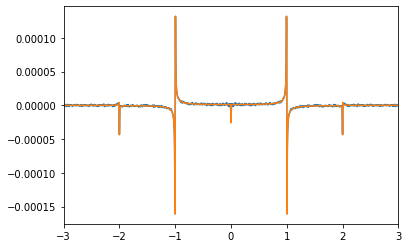

In [24]:
_, ax = plt.subplots()
ax.plot(dum.userkws['frequencies'], dum.data.real)
ax.plot(dum.userkws['frequencies'], dum.eval().real)
# ax.plot(dum.userkws['frequencies'], dum.data.imag)
# ax.plot(dum.userkws['frequencies'], dum.eval().imag)
ax.set_xlim(-3,3)